In [1]:
%load_ext memory_profiler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from scipy.optimize import linear_sum_assignment
import gurobipy as gp
from mip import *
import numpy as np
import pandas as pd 
import numpy.random as npr
import scipy.special
import sys, string, copy, itertools, time, warnings

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
import plotnine
from plotnine import *

In [4]:
npr.seed(1984)

# Difference of rocustness using different designs

Here we examine how well we can recover the donor identities when genotype clustering is noisy.

Ideally, each genotype cluster matches exactly with one of the designed pooling profiles, say if donor 1 is asigned to pool 1, 3, 5 while donor 2 is assigned to 2, 3, 5, there would be exactly one cluster contains only cells from pool 1, 3, 5 and another contains only cells from pool 2, 3, 5. 

Imperfect clustering means that the matching between the designed profiles and the observed pool compositions is noisy: both clusters corresponding to donor 1 and 2 may contain cells from all pools but one enriched for those from 1, 3, 5 and the other enriched for pool 2, 3, 5. Say the pool compositions of the two clusters look like (0.28, 0.07, 0.30, 0.05, 0.27, 0.03) v.s. (0.05, 027, 0.28, 0.07, 0.30, 0.03). We could still assign the observed genotype clusters to each donor when the signal to noise ratio is high. 

For two donors with assignment 1,3,5 v.s. 2,4,6, it is very unlikely they would be mistaken even with high level of noise. A robust design tries to maximize the difference between donors. 

In [5]:
N = 64 # Number of individuals (donors)
P = 12 # Number of pools 
C = 6  # Number of experimental conditions 

In [6]:
code_mat_list = [] # logarithmic, robust, compact
code_mat = [] # N x P, design matrix

# logarithmic
for n in range(N):
    ind_code = ('{0:0%sb}' % int(np.log2(N))).format(n)
    ls_code = [int(x) for x in str(ind_code)]
    ls_code.extend([1-x for x in ls_code])
    code_mat.append(ls_code)
code_mat = np.array(code_mat, dtype=int)
code_mat_list.append(code_mat)

# Load pre-computed designs
for f in ["./example/N64_P11_C6_m4.design", "./example/N64_P9_C6_m2.design"]:
    with open(f, 'r') as rf:
        lines = rf.readlines()
    code = [x.strip().split(' ') for x in lines]
    p = len(lines)
    code_mat = []
    for i in range(p):
        code_mat.append([0]*N)
        for j in range(N):
            if code[i][j] == ".":
                code_mat[i][j] = 0
            else:
                code_mat[i][j] = ord(code[i][j])-96
    code_mat_list.append(np.array(code_mat,dtype=int).transpose())             

In [7]:
[x.shape for x in code_mat_list] # Shape of the design matrix, donor by pool

[(64, 12), (64, 11), (64, 9)]

In [8]:
noise_level = [0.05, 0.1,0.2, 0.3, 0.4, 0.5]
n_failure = [1,2,3,4,5] # Number of pools that fail (completely)
p_list = [12, 11, 9] # Number of pools used in each scheme 
scheme = [ "Canonical", "Robust", "MostCompact" ]

In [9]:
R = 100 # Number of random noise simulation (There is not much randomness except for the logarithmic design)
robuset_res = [] # coding_scheme, noise_level, pool_faliure, n_correct, repeat 

for m_iter in range(len(code_mat_list)):
    b = p_list[m_iter] # Number of pools in this design 
    for f_iter in range(len(n_failure)):
        m = n_failure[f_iter] # Number of failed pools 
        for n_iter in range(len(noise_level)):
            # Simulate clustering results with different noise levels 
            for r in range(R):
                assign = np.arange(N)
                npr.shuffle(assign)
                cluster = np.zeros((N, N)) # (Miss)assignment of donors to clusters 
                for i in range(N):
                    cluster[i, assign[i]] = 1 # Ideal case - each cluster corresponds to exactly one donor 
                err = npr.rand(N, N) * cluster 
                err = err / err.sum() * N # Scale the total noise to sum to N (same as signal)
                # Then scale the noise to signal ratio to the desiend level
                err = err * noise_level[n_iter] / (1.-noise_level[n_iter]) 
                cluster = cluster + err # Probability of belonging to each cluster for the n individuals

                B = code_mat_list[m_iter].transpose() # Design matrix b x N
                if m > 0:
                    miss = npr.randint(0,b,size=m) # Random sample m pools to fail
                    B = np.array([B[x] for x in range(b) if x not in miss])
                C = np.matmul(B, cluster) # Cluster proportion for each batch b x n
                # Matching cost N x N (between clusters and donors)
                D = [ [ sum((B[:,j]-C[:,i])**2) for i in range(N) ] for j in range(N)] 
                # Solve for the minimum cost matching 
                row_ind, col_ind = linear_sum_assignment(D)
                correct = [i for i,x in enumerate(col_ind) if x == assign[i]]
                res = [scheme[m_iter],noise_level[n_iter],m,len(correct),r]
                robuset_res.append(res)
        print(m_iter, f_iter)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4


In [10]:
robust_df = pd.DataFrame(robuset_res, columns =\
                         ['Coding_scheme','Noise_level','Pool_failure','Correct_recover','Repeat'])
                                                  

In [11]:
robust_df.Noise_level = pd.Categorical(robust_df.Noise_level,categories=noise_level, ordered=True)

In [12]:
f = "./example/robustness_evaluation.tsv"
robust_df.to_csv(f, sep='\t', index=False, header=True)

In [13]:
df = robust_df.groupby(by=['Coding_scheme', 'Noise_level', 'Pool_failure'], \
                       as_index=False).agg({'Correct_recover':[np.mean,np.std]})

df.columns = ['Coding_scheme', 'Noise_level', 'Pool_failure','Avg_recover','Std_recover']
df.Pool_failure = pd.Categorical(df.Pool_failure, categories=n_failure, ordered=True)
df['Group'] = df.Coding_scheme.values + '_' + df.Pool_failure.astype(str)
df['Avg_error'] = N - df.Avg_recover
df['R'] = R
df['Lower']=df.Avg_error-df.Std_recover/np.sqrt(df.R.values)
df['Upper']=df.Avg_error+df.Std_recover/np.sqrt(df.R.values)

In [14]:
cmap = cm.get_cmap('turbo', len(n_failure))
clist = [matplotlib.colors.rgb2hex(cmap(k)) for k in range(len(n_failure))]

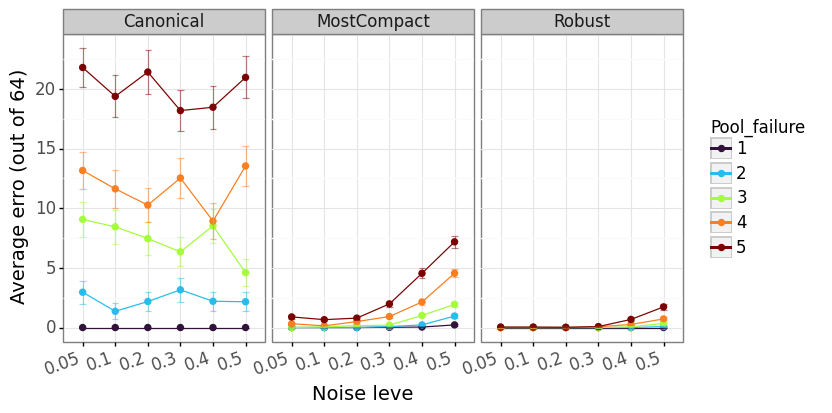

<ggplot: (8776416660682)>

In [15]:
plotnine.options.figure_size = (8,4)
with warnings.catch_warnings(record=True):
    (
    ggplot(df,
           aes(x='Noise_level',y='Avg_error',color='Pool_failure')) +
    geom_point(shape='o',size=2) + 
    geom_line(aes(group='Pool_failure')) +
    facet_wrap('Coding_scheme') +
    geom_errorbar(aes(ymin='Lower', ymax='Upper'), width=.2, alpha=0.5) +
    scale_color_manual(values = clist) +
    xlab("Noise leve") + ylab("Average erro (out of 64)") +
    theme_bw() +
    theme(strip_text = element_text(size=12)) +
    theme(legend_text=element_text(size=12), legend_title=element_text(size=12)) +
    theme(axis_text_x = element_text(size=12,rotation=20, hjust=1), axis_text_y = element_text(size=12)) +
    theme(axis_title_x=element_text(size=14), axis_title_y=element_text(size=14))
    )